In [ ]:
from google.colab import files
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import glob,os
import matplotlib.image as mpimg

In [ ]:
!pip install -q kaggle
files.upload()
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!kaggle datasets download -d jojomoolayil/catsvsdogs
! mkdir train
! unzip catsvsdogs.zip -d dataset

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print("Device:",device)

Device: cuda


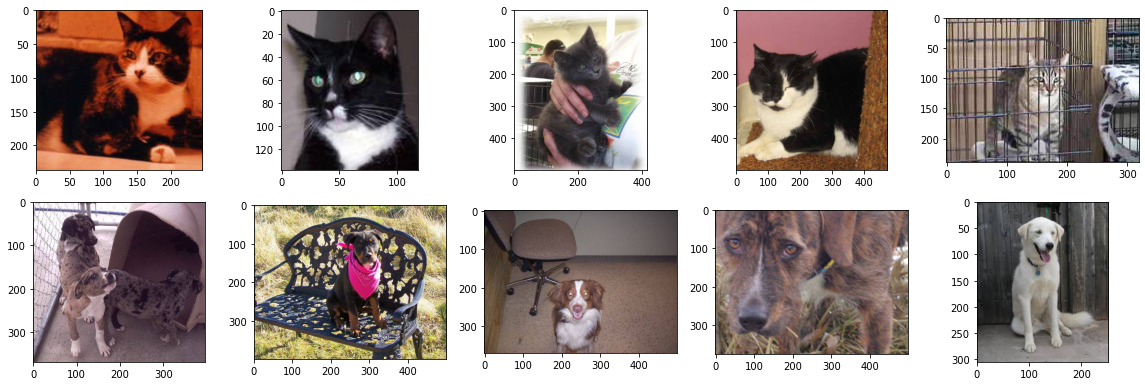

In [ ]:
new_path = "/content/dataset"
%matplotlib inline
images = []
#Collect Cat images
for img_path in glob.glob(os.path.join(new_path,"train","cat","*.jpg"))[:5]:
  images.append(mpimg.imread(img_path))
for img_path in glob.glob(os.path.join(new_path,"train","dog","*.jpg"))[:5]:
  images.append(mpimg.imread(img_path))
#Plot a grid of cats and Dogs
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
  plt.subplot(len(images) / columns + 1, columns, i + 1)
  plt.imshow(image)

In [ ]:
train_dir = '/content/dataset/train'

In [ ]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.4885, 0.4552, 0.4168])
Calculated stds: tensor([0.2296, 0.2251, 0.2253])


In [ ]:
transformations = transforms.Compose([
  transforms.Resize(255),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.4885, 0.4552, 0.4168], std=[0.2296, 0.2251, 0.2253])
])
train_set = datasets.ImageFolder(os.path.join(new_path, 'train'), transform = transformations)
val_set = datasets.ImageFolder(os.path.join(new_path, 'test'), transform = transformations)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =32, shuffle=True)

In [ ]:
def create_cnn(in_c, out_c):
  return nn.Sequential(
    nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2)
    )
class ConvNet(nn.Module):
  def __init__(self, num_classes = 2) -> None:
      super(ConvNet, self).__init__()
      self.conv_unit1 = create_cnn(3, 16)
      self.conv_unit2 = create_cnn(16, 32)
      self.conv_unit3 = create_cnn(32, 64)
      self.conv_unit4 = create_cnn(64, 128)
      self.classifier = nn.Sequential(
          nn.Linear(14*14*128, 128),
          nn.Linear(128, 1),
          nn.Sigmoid()
      )
  def forward(self, x):
    x = self.conv_unit1(x)
    x = self.conv_unit2(x)
    x = self.conv_unit3(x)
    x = self.conv_unit4(x)
    x = x.view(x.size(0),-1)
    out = self.classifier(x)
    return out

In [ ]:
def evaluate(model,data_loader):
  loss = []
  correct = 0
  with torch.no_grad():
    for images, labels in data_loader:
      images = images.to(device)
      labels = labels.to(device)
      model.eval()
      output = model(images)
      predicted = output > 0.5
      correct += (labels.reshape(-1,1) == predicted.
      reshape(-1,1)).float().sum()
      #Clear memory
      del([images,labels])
      if device == "cuda":
        torch.cuda.empty_cache()
    print('\nVal Accuracy: {}/{} ({:.3f}%)\n'.format(correct, len(data_loader.dataset), 100. * correct / len(data_loader.dataset)))

In [ ]:
num_epochs = 10
loss_function = nn.BCELoss() #Binary Crosss Entropy Loss
model = ConvNet()
model.cuda()
adam_optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
# Train the model
total_step = len(train_loader)
print("Total Batches:",total_step)

Total Batches: 625


In [ ]:
for epoch in range(num_epochs):
  model.train()
  train_loss = 0
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = model(images)
    loss = loss_function(outputs.float(), labels.float().view(-1,1))
    # Backward and optimize
    adam_optimizer.zero_grad()
    loss.backward()
    adam_optimizer.step()
    train_loss += loss.item()* labels.size(0)
  print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1,
  num_epochs, loss.item()))
  #Evaluate model after each training epoch
  evaluate(model,val_loader)

Epoch [1/10], Loss: 0.4644

Val Accuracy: 3743.0/5000 (74.860%)

Epoch [2/10], Loss: 0.2831

Val Accuracy: 3958.0/5000 (79.160%)

Epoch [3/10], Loss: 0.4670

Val Accuracy: 4152.0/5000 (83.040%)

Epoch [4/10], Loss: 0.3078

Val Accuracy: 4209.0/5000 (84.180%)

Epoch [5/10], Loss: 0.2750

Val Accuracy: 4239.0/5000 (84.780%)

Epoch [6/10], Loss: 0.1784

Val Accuracy: 4306.0/5000 (86.120%)

Epoch [7/10], Loss: 0.1281

Val Accuracy: 4290.0/5000 (85.800%)

Epoch [8/10], Loss: 0.1046

Val Accuracy: 4264.0/5000 (85.280%)

Epoch [9/10], Loss: 0.2411

Val Accuracy: 4278.0/5000 (85.560%)

Epoch [10/10], Loss: 0.0311

Val Accuracy: 4238.0/5000 (84.760%)



In [ ]:
#Download the model (pretrained)
from torchvision import models
new_model = models.vgg16(pretrained=True)
# Freeze model weights
for param in new_model.parameters():
  param.requires_grad = False
print(new_model.classifier)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [ ]:
new_model.classifier[6] = nn.Sequential(
  nn.Linear(new_model.classifier[6].in_features, 256),
  nn.ReLU(),
  nn.Dropout(0.4),
  nn.Linear(256, 1),
  nn.Sigmoid()
  )
total_params = sum(p.numel() for p in new_model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in new_model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,309,633 total parameters.
1,049,089 training parameters.


In [ ]:
num_epochs = 10
loss_function = nn.BCELoss() #Binary Crosss Entropy Loss
new_model.cuda()
adam_optimizer = torch.optim.Adam(new_model.parameters(), lr= 0.001)
# Train the model
total_step = len(train_loader)
print("Total Batches:",total_step)
for epoch in range(num_epochs):
  new_model.train()
  train_loss = 0
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = new_model(images)
    loss = loss_function(outputs.float(), labels.float().view(-1,1))
    adam_optimizer.zero_grad()
    loss.backward()
    adam_optimizer.step()
    train_loss += loss.item()* labels.size(0)
  print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1,
  num_epochs, loss.item()))
  #After each epoch evaluate model
  evaluate(new_model,val_loader)

Total Batches: 625
Epoch [1/10], Loss: 0.0424

Val Accuracy: 4933.0/5000 (98.660%)

Epoch [2/10], Loss: 0.0765

Val Accuracy: 4937.0/5000 (98.740%)

Epoch [3/10], Loss: 0.0379

Val Accuracy: 4927.0/5000 (98.540%)

Epoch [4/10], Loss: 0.0454

Val Accuracy: 4944.0/5000 (98.880%)

Epoch [5/10], Loss: 0.0236

Val Accuracy: 4938.0/5000 (98.760%)

Epoch [6/10], Loss: 0.0000

Val Accuracy: 4924.0/5000 (98.480%)

Epoch [7/10], Loss: 0.0017

Val Accuracy: 4946.0/5000 (98.920%)

Epoch [8/10], Loss: 0.0003

Val Accuracy: 4935.0/5000 (98.700%)

Epoch [9/10], Loss: 0.0008

Val Accuracy: 4931.0/5000 (98.620%)

Epoch [10/10], Loss: 0.0003

Val Accuracy: 4933.0/5000 (98.660%)

